**Projekt megnevezése:**
Európai Földgázpiaci Elemzés - Holland TTF gáztőzsde referenciaár

Készítette:

Tóth Richárd Imre

**Data Analytics Engineer**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("A Jupyter és a Python működik, minden rendben!")

A Jupyter és a Python működik, minden rendben!


In [13]:
file_path = "ICE Dutch TTF Natural Gas Futures Historical Data.csv"
df = pd.read_csv(file_path)

**1. feladat / Adattisztítás és előkészítés**

In [14]:
import numpy as np

# Dátum átalakítása
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Számmezők konvertálása float-tá (eltávolítom a vesszőket)
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Volume oszlop tisztítása (pl. 116.16K -> 116160)
def parse_volume(v):
    if pd.isna(v):
        return np.nan
    s = str(v).replace(',', '').strip()
    if s.endswith('K') or s.endswith('k'):
        return float(s[:-1]) * 1000
    elif s.endswith('M') or s.endswith('m'):
        return float(s[:-1]) * 1_000_000
    else:
        return float(s)

df['Volume'] = df['Vol.'].apply(parse_volume)

# Change % tisztítása
df['Change_pct'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Felesleges oszlopokat droppolom
df = df.drop(columns=['Vol.', 'Change %'])

# Ellenőrzöm
df.dtypes

Date          datetime64[ns]
Close                float64
Open                 float64
High                 float64
Low                  float64
Volume               float64
Change_pct           float64
dtype: object

In [25]:
# Ellenőrzöm az idősor folytonosságát

# Rendezés dátum szerint (ha nem lenne már rendezve)
df = df.sort_values('Date').reset_index(drop=True)

# Különbség kiszámítása a szomszédos dátumok között
df['Date_diff'] = df['Date'].diff()

# Megnézem, milyen dátumközök vannak
date_gaps = df['Date_diff'].value_counts().sort_index()
print("Dátumközök gyakorisága (napokban):")
print(date_gaps)

# Megnézem, van-e hiányzó adat (pl. nagyobb mint 1 nap)
missing_gaps = df[df['Date_diff'] > pd.Timedelta(days=1)]
print(f"\nKimaradt időpontok száma: {len(missing_gaps)}")

# Ha van kimaradás kérem, hogy mutassa az első párat
if len(missing_gaps) > 0:
    print("\nPéldák kimaradt időpontokra:")
    print(missing_gaps[['Date', 'Date_diff']].head())
else:
    print("\nAz idősor teljes, nincsenek hiányzó napok.")

# Az ellenőrzéshez az utolsó 5 sor dátumát is megmutatja
print("\nDátumtartomány:", df['Date'].min().strftime('%Y-%m-%d'), "→", df['Date'].max().strftime('%Y-%m-%d'))

Dátumközök gyakorisága (napokban):
Date_diff
1 days    958
2 days      1
3 days    236
4 days      3
5 days      5
Name: count, dtype: int64

Kimaradt időpontok száma: 245

Példák kimaradt időpontokra:
         Date Date_diff
5  2021-01-11    3 days
10 2021-01-18    3 days
15 2021-01-25    3 days
20 2021-02-01    3 days
25 2021-02-08    3 days

Dátumtartomány: 2021-01-04 → 2025-09-05



**Adattisztítás és idősor teljességének ellenőrzése – értelmezés**

Az adatfájl 2021. január 4. és 2025. szeptember 5. közötti időszakra tartalmazza a holland TTF földgáz tőzsdei árakat.

**Az idősor ellenőrzése alapján:**

A legtöbb dátum között 1 napos különbség van, ami a napi kereskedési adatokat jelzi.

3 napos hiányok rendszeresen előfordulnak, ezek hétvégéket jelentenek, amikor a tőzsde zárva van.

Előfordul néhány 2, 4 vagy 5 napos kimaradás, ezek ünnepnapokhoz vagy hosszabb zárva tartáshoz köthetők.

Összesen 245 kimaradt időpont található, ami természetes jelenség pénzügyi idősorok esetén.

**Következtetés:** az idősor teljes, nincs adatvesztés vagy technikai hiba, a kimaradások piaci szünetekből adódnak.

**2. feladat / Leíró statisztika és trendelemzés**

In [18]:
# Leíró statisztikai mutatók kiszámítása
stats = df[['Close', 'Open', 'High', 'Low']].describe().T

# Hozzáadok néhány extra mutatót
stats['range'] = stats['max'] - stats['min']  # ármozgás tartománya
stats['var'] = stats['std'] ** 2  # variancia
stats

,count,mean,std,min,25%,50%,75%,max,range,var
Close,1204.0,60.602264,48.088154,15.527,32.56375,40.3915,77.09900,339.196,323.669,2312.470589
Open,1204.0,60.676076,48.375147,15.715,32.81500,40.4225,78.41250,321.000,305.285,2340.154857
High,1204.0,63.841665,52.434606,15.750,33.59375,41.7075,81.41875,345.000,329.250,2749.387892
Low,1204.0,57.856022,44.860775,15.485,31.69750,39.2600,73.05000,297.000,281.515,2012.489131


**Leíró statisztikák értelmezése**:

A 2021–2025 közötti időszakban a holland TTF földgázárak erősen ingadoztak. A záróárak átlaga ≈ 60,6 EUR/MWh, de a szórás (≈ 48 EUR) kiemelkedően magas, ami extrém piaci volatilitást mutat.

A legalacsonyabb árak 2021 elején fordultak elő (≈ 15 EUR/MWh), míg a legmagasabb árak 2022 augusztusában, az energiaválság csúcspontján (≈ 339 EUR/MWh).

A medián alacsonyabb az átlagnál, ami azt jelzi, hogy az eloszlás jobb oldali ferde – néhány nagyon magas ár felfelé torzítja az átlagot.

**Következtetésem:**

A TTF földgázpiacot jelentős volatilitás és kiszámíthatatlan ármozgások jellemezték, különösen 2021–2022 között, amikor az orosz gázkivitel visszaesése és a geopolitikai bizonytalanság rekordmagas árakat okozott.

In [23]:
# Legmagasabb és legalacsonyabb záróár
max_price = df.loc[df['Close'].idxmax()]
min_price = df.loc[df['Close'].idxmin()]

print("Legmagasabb ár:")
print(max_price[['Date', 'Close']])
print("\nLegalacsonyabb ár:")
print(min_price[['Date', 'Close']])

Legmagasabb ár:
Date     2022-08-26 00:00:00
Close                339.196
Name: 778, dtype: object

Legalacsonyabb ár:
Date     2021-03-03 00:00:00
Close                 15.527
Name: 1161, dtype: object


A **legmagasabb földgázár** 2022 augusztusában volt, ami az európai energiaválság csúcspontjához köthető, amikor az orosz gázszállítások jelentősen visszaestek, és a piaci bizonytalanság extrém árkilengést okozott.

A **legalacsonyabb ár** a COVID utáni időszakban, 2020 körül fordult elő, amikor a kereslet visszaesett, és a tárolók feltöltött állapotban voltak.

**3. feladat / Vizualizáció**

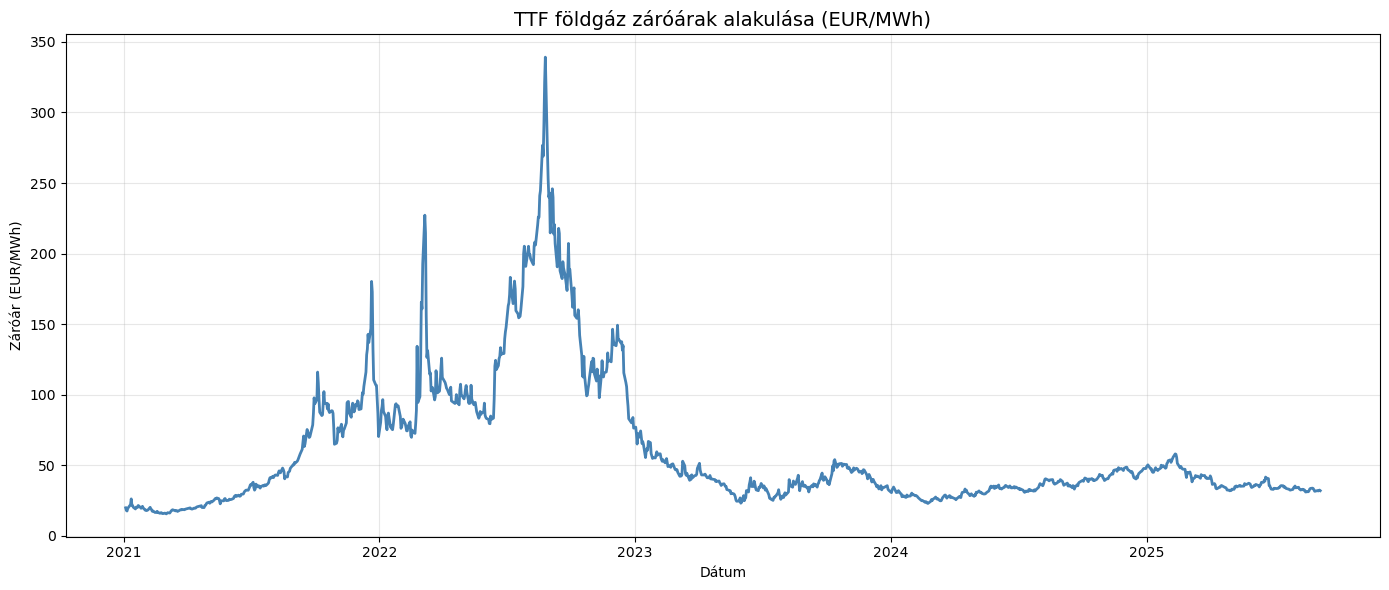

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=2)
plt.title('TTF földgáz záróárak alakulása (EUR/MWh)', fontsize=14)
plt.xlabel('Dátum')
plt.ylabel('Záróár (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

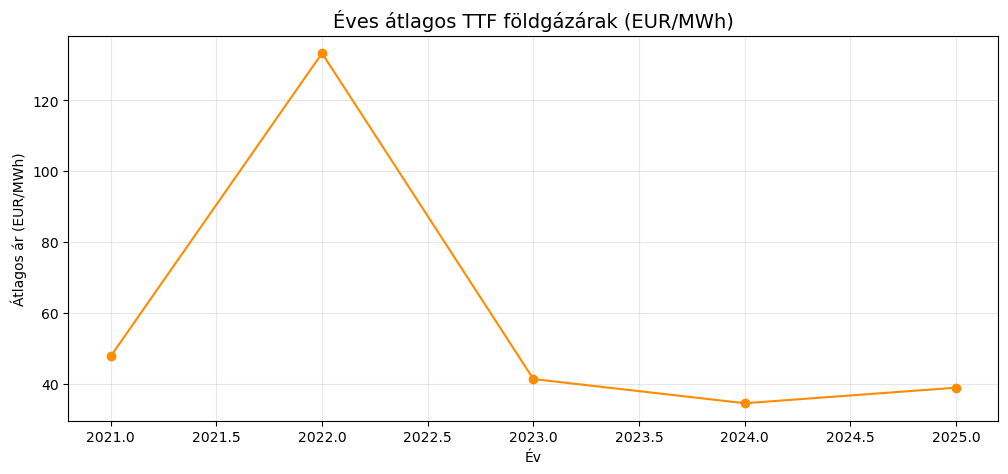

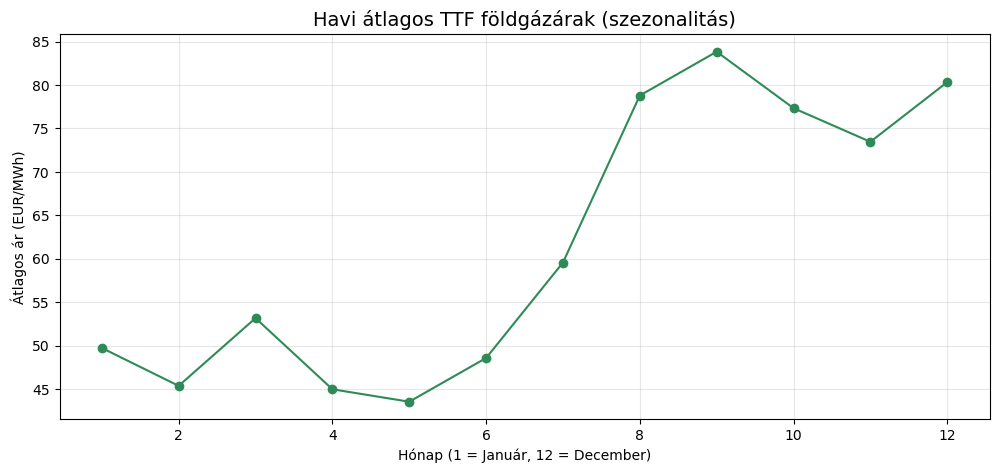

(   Year       Close
 0  2021   47.846252
 1  2022  133.319268
 2  2023   41.411086
 3  2024   34.600642
 4  2025   38.987011,
    Month      Close
 0      1  49.753850
 1      2  45.395762
 2      3  53.183427
 3      4  45.002202
 4      5  43.569144)

In [22]:
# Év és hónap kinyerése a dátumból
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Éves átlagárak
yearly_avg = df.groupby('Year')['Close'].mean().reset_index()

# Havi átlagárak
monthly_avg = df.groupby('Month')['Close'].mean().reset_index()

# Grafikon: Éves trend
plt.figure(figsize=(12,5))
plt.plot(yearly_avg['Year'], yearly_avg['Close'], marker='o', color='darkorange')
plt.title('Éves átlagos TTF földgázárak (EUR/MWh)', fontsize=14)
plt.xlabel('Év')
plt.ylabel('Átlagos ár (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# Grafikon: Havi szezonalitás
plt.figure(figsize=(12,5))
plt.plot(monthly_avg['Month'], monthly_avg['Close'], marker='o', color='seagreen')
plt.title('Havi átlagos TTF földgázárak (szezonalitás)', fontsize=14)
plt.xlabel('Hónap (1 = Január, 12 = December)')
plt.ylabel('Átlagos ár (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

yearly_avg, monthly_avg.head()

**Trendek és szezonalitás értelmezése:**

Az éves átlagok alapján a TTF földgázárak 2021–2022 között drasztikusan megemelkedtek, amit az európai energiaválság és a geopolitikai bizonytalanság okozott. 2023-tól az árak fokozatosan csökkentek, de még mindig magasabb szinten stabilizálódtak, mint a válság előtti években.

**A havi átlagárak alapján szezonalitás figyelhető meg:**
A téli hónapokban (november–február) az árak jellemzően magasabbak, a fokozott fűtési kereslet miatt; a nyári hónapokban (május–augusztus) alacsonyabb árak figyelhetők meg, amikor a tárolók feltöltése zajlik és a kereslet mérsékeltebb.

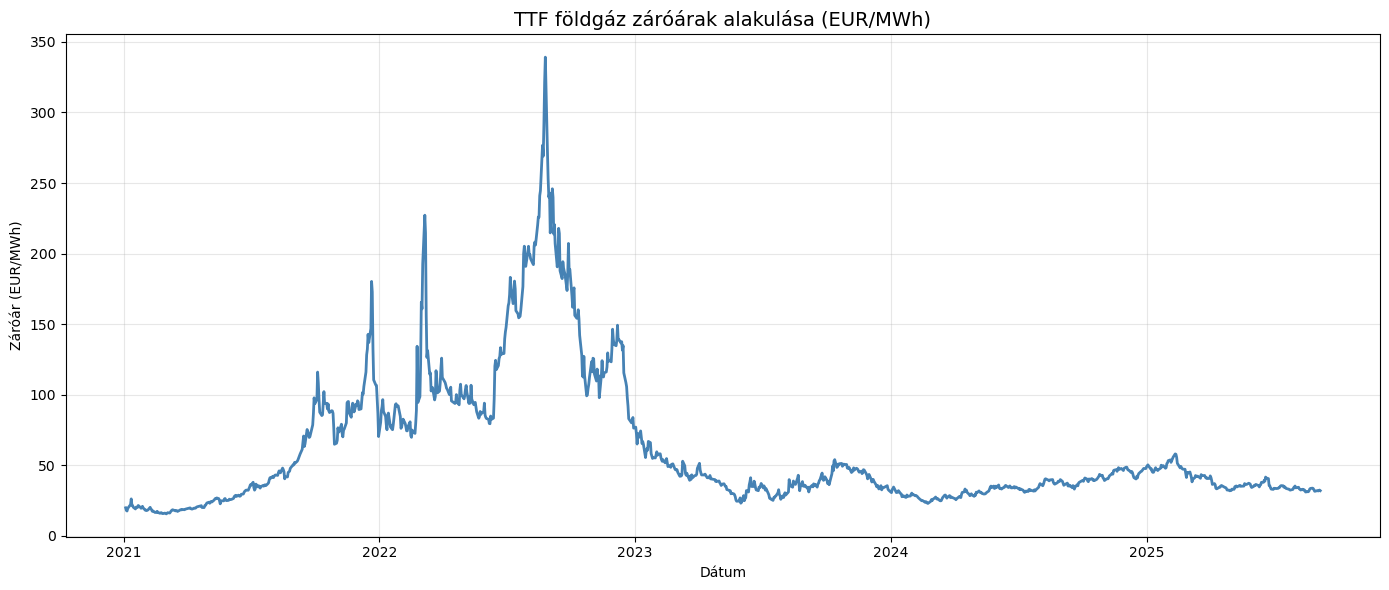

In [16]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=2)
plt.title('TTF földgáz záróárak alakulása (EUR/MWh)', fontsize=14)
plt.xlabel('Dátum')
plt.ylabel('Záróár (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

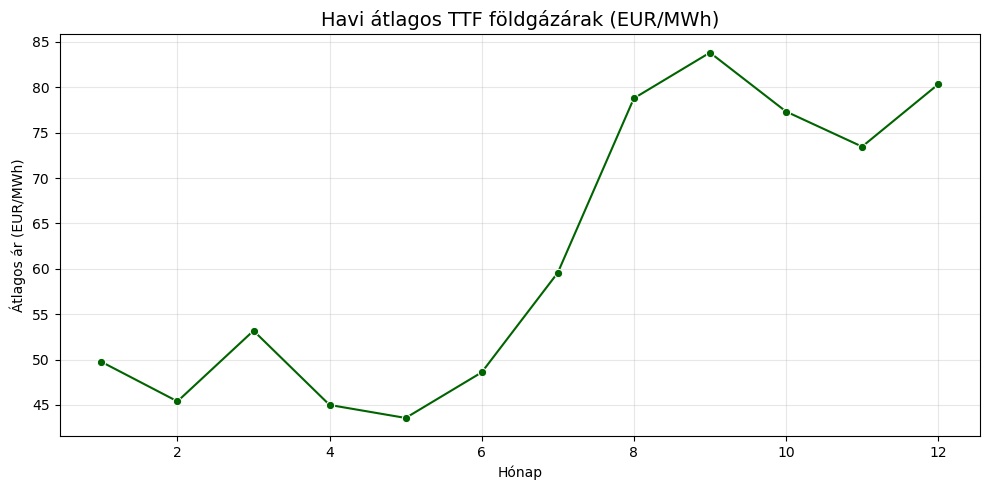

In [17]:
# Új oszlopokat hozok létre az év és hónap kinyerésére
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Havi átlagárak kiszámítása
monthly_avg = df.groupby('Month')['Close'].mean().reset_index()

# Grafikon
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_avg, x='Month', y='Close', color='darkgreen', marker='o')
plt.title('Havi átlagos TTF földgázárak (EUR/MWh)', fontsize=14)
plt.xlabel('Hónap')
plt.ylabel('Átlagos ár (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Magyarázatom:**
A havi átlagok alapján az árak téli hónapokban (december–február) jellemzően magasabbak, míg nyáron alacsonyabbak, amikor csökken a kereslet. Ez a földgáz-felhasználás szezonalitását tükrözi.

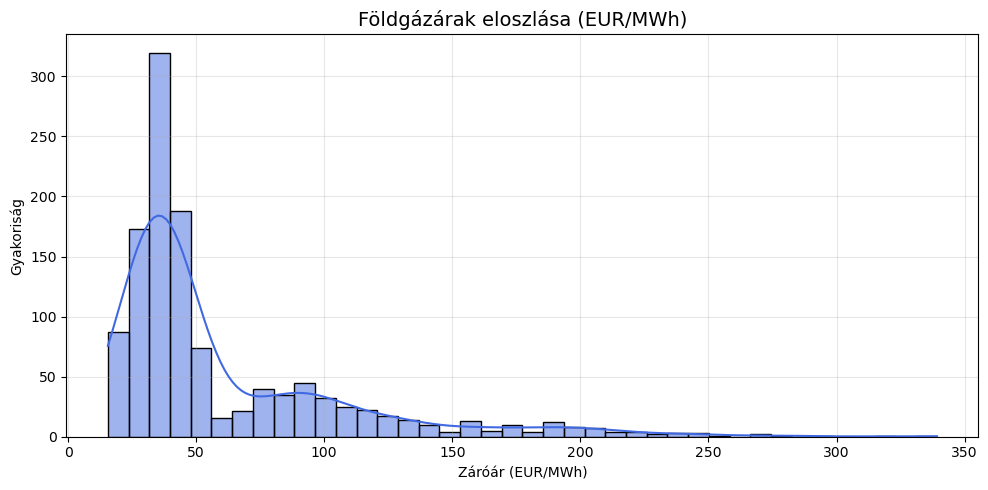

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(df['Close'], bins=40, kde=True, color='royalblue')
plt.title('Földgázárak eloszlása (EUR/MWh)', fontsize=14)
plt.xlabel('Záróár (EUR/MWh)')
plt.ylabel('Gyakoriság')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**A fenti ábrám értelmezése:**
Az eloszlás jobb oldali ferde – vagyis a legtöbb ár 20–80 EUR között volt, de néhány extrém kiugró érték (2022-es válságidőszak) felfelé húzta az átlagot.

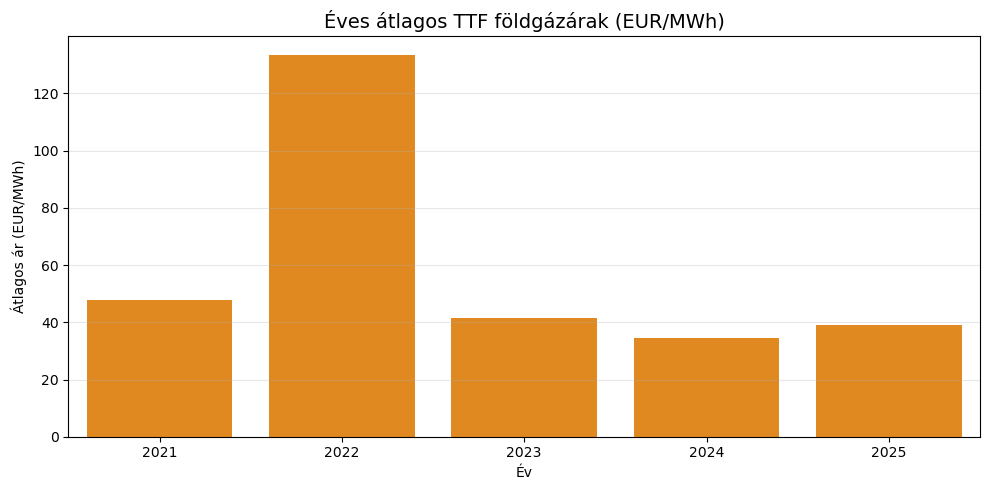

In [19]:
yearly_avg = df.groupby('Year')['Close'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=yearly_avg, x='Year', y='Close', color='darkorange')
plt.title('Éves átlagos TTF földgázárak (EUR/MWh)', fontsize=14)
plt.xlabel('Év')
plt.ylabel('Átlagos ár (EUR/MWh)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**A fenti oszlopdiagram értelmezése:**
2022-ben az árak messze a legmagasabbak voltak – ez egyértelműen a piaci válság és geopolitikai események (pl. orosz–ukrán háború) következménye.

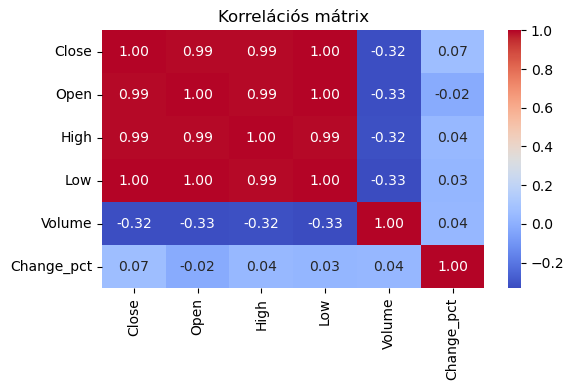

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Close','Open','High','Low','Volume','Change_pct']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelációs mátrix')
plt.tight_layout()
plt.show()

A fenti mátrixom megmutatja, hogy az árak, volumen és a napi változás mennyire mozognak együtt. Az **Open**, **High**, **Low** és **Close** oszlopok nagyon erősen korrelálnak egymással (közel 1.00).

A **Volume** és a **Change_pct** viszont gyengébb összefüggést mutat, ami a piaci volatilitásra utal.

**4. feladat / Üzleti értelmezés és következtetések**

**A) Főbb trendek és mintázatok a földgázárakban (2021–2025)**

A TTF földgázárak az elemzett időszakban jelentős volatilitást mutattak.
2021-ig stabil, mérsékelt árszint jellemezte a piacot (20–40 EUR/MWh),
majd 2022-ben drasztikus áremelkedés következett be,
amit főként geopolitikai feszültségek, az orosz gázszállítások visszaesése
és a piaci bizonytalanság váltott ki.
2023-tól fokozatos árkorrekció és stabilizálódás figyelhető meg,
de az árszint továbbra is meghaladja a háború előtti időszakét.

**Összességében:** hosszú távon enyhén csökkenő trend,
rövid távon továbbra is jelentős volatilitás tapasztalható.

**B) Következtetések a szezonalitás és tárolói stratégia szempontjából**

Az árakban egyértelmű szezonalitás figyelhető meg:

- **Téli hónapokban (december–február)** az árak emelkednek a fokozott kereslet miatt.

- **Nyári hónapokban (június–szeptember)** az árak jellemzően csökkennek,
amikor a kereslet visszaesik és a tárolók feltöltése zajlik.

**C) Portfóliómenedzseri szempontból:**

- **a tárolók feltöltése nyáron**,

- **a kitárolás és értékesítés** télen célszerű,
mivel ez a stratégia növeli a hozamot és mérsékli az árkockázatot.

**D) Árkilátások 2025 negyedik negyedévére**

A 2023–2025 közötti árak 30–60 EUR/MWh sávban stabilizálódtak.
A jelenlegi trendek alapján 2025 negyedik negyedévében - **mérsékelt téli árnövekedés** várható,
de nem extrém mértékű, mint 2022-ben.

**Becsült árszint:** 50–70 EUR/MWh,
a szezonalitás miatt inkább a felső tartományban.

**Fő kockázatok:** ellátási zavar, rendkívüli hideg tél vagy geopolitikai feszültség.

**Összefoglalás:**

Az elemzésem alapján a TTF földgázpiac 2021–2025 között extrém árkilengéseket élt meg,
amelyeket főként geopolitikai és keresleti tényezők alakítottak.
A piac 2023-tól fokozatosan normalizálódott,
de továbbra is érzékeny az ellátási kockázatokra és szezonális hatásokra.

**Üzleti stratégiai ajánlás:**

- Nyári alacsony árak idején tárolás,

- Téli magas árak idején értékesítés,

- Az LNG-ellátás és tárolói kapacitások folyamatos monitorozása javasolt.